In [1]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from pathlib import Path

import glob
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset  # Ensure Dataset is imported
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim

import cv2
from matplotlib.image import imread

import tensorflow as tf
#from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import glob
import PIL
import random

random.seed(100)


Num GPUs Available:  0


In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ambarish/breakhis")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4


In [14]:
import os

dataset_path = r"C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4"
print("Dataset path:", os.path.abspath(dataset_path))

# List files in the dataset folder
files = os.listdir(dataset_path)
print("Files in dataset:", files[:10])  # Show the first 10 files for checking


Dataset path: C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4
Files in dataset: ['BreaKHis_v1', 'Folds.csv']


In [8]:
import glob

# Find all image paths in the dataset
breast_img_paths = glob.glob(os.path.join(dataset_path, '**/*.png'), recursive=True)

# Verify that the image paths are correct



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import os
from scipy import ndimage # For distance transform and morphological operations

def load_and_preprocess(image_path):
    """Load and preprocess the image"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not load image {image_path}")
            return None

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Contrast enhancement (Apply per channel or convert to grayscale/LAB)
        # Applying CLAHE on RGB can sometimes distort colors. Let's apply on Value channel in HSV.
        img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        v_enhanced = clahe.apply(v)

        img_hsv_enhanced = cv2.merge([h, s, v_enhanced])
        img_rgb_enhanced = cv2.cvtColor(img_hsv_enhanced, cv2.COLOR_HSV2RGB)

        # Convert back to uint8 after enhancement if needed (exposure.equalize_adapthist returns float)
        # Since we applied CLAHE on uint8 V channel, the result is uint8.

        return img_rgb_enhanced

    except Exception as e:
        print(f"Error during preprocessing {image_path}: {e}")
        return None

def apply_kmeans(img_rgb, k=3):
    """Apply K-means clustering with optimized parameters"""
    try:
        # Reshape the image to a 2D array of pixels
        pixel_values = img_rgb.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        # Define criteria with more iterations for better convergence
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.1) # Increased iterations
        flags = cv2.KMEANS_RANDOM_CENTERS # Use random centers initialization

        # Perform K-means with multiple attempts to avoid local minima
        # Increased attempts
        _, labels, centers = cv2.kmeans(
            pixel_values, k, None, criteria, 10, flags
        )

        # Convert centers back to 8-bit values
        centers = np.uint8(centers)

        return labels, centers

    except Exception as e:
        print(f"Error during K-means: {e}")
        return None, None

def postprocess_kmeans_labels(labels, img_shape):
    """Reshape and apply median filter to K-means labels"""
    try:
        labels_reshaped = labels.reshape((img_shape[0], img_shape[1]))

        # Apply median filter to reduce noise in the initial labels
        labels_reshaped = cv2.medianBlur(labels_reshaped.astype(np.uint8), 5) # Increased kernel size

        return labels_reshaped

    except Exception as e:
        print(f"Error during post-processing K-means labels: {e}")
        return None

def generate_watershed_markers(kmeans_labels_reshaped, tumor_cluster_id):
    """Generate markers for Watershed from the K-means tumor cluster"""
    try:
        # Create a binary mask for the tumor cluster
        tumor_mask = (kmeans_labels_reshaped == tumor_cluster_id).astype(np.uint8) * 255

        # --- Generate Sure Foreground Markers ---
        # Apply morphological opening to remove small noise within the tumor area
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(tumor_mask, cv2.MORPH_OPEN, kernel, iterations=2) # More iterations

        # Apply distance transform to the opened mask
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

        # Threshold the distance transform to get sure foreground regions
        # Pixels very far from the background are likely foreground
        ret, sure_fg = cv2.threshold(dist_transform, 0.05 * dist_transform.max(), 255, 0) # Adjusted threshold

        sure_fg = np.uint8(sure_fg)

        # --- Generate Sure Background Markers ---
        # Dilate the tumor mask significantly to get an area considered background
        sure_bg_area = cv2.dilate(tumor_mask, kernel, iterations=3) # More dilation
        sure_bg = cv2.bitwise_not(sure_bg_area) # Invert to get sure background

        # --- Identify Unknown Region ---
        unknown = cv2.subtract(sure_bg, sure_fg)

        # --- Create Marker Image for Watershed ---
        # Label the sure foreground regions
        _, markers = cv2.connectedComponents(sure_fg)

        # Add one to all labels so that sure background is 1, not 0 (Watershed treats 0 as unknown)
        markers = markers + 1

        # Mark the unknown region with 0
        markers[unknown == 255] = 0

        return markers, tumor_mask, sure_fg, sure_bg, unknown

    except Exception as e:
        print(f"Error during marker generation: {e}")
        return None, None, None, None, None

def apply_watershed(img_rgb, markers):
    """Apply Watershed algorithm using generated markers"""
    try:
        # Convert image to the format required by watershed (must be 3-channel)
        # The original img_rgb is already 3-channel.
        img_copy = img_rgb.copy()

        # Apply the watershed algorithm
        # cv2.watershed modifies the markers image in-place
        watershed_labels = cv2.watershed(img_copy, markers)

        # Watershed output labels: -1 for boundaries, 1 for background, 2+ for objects
        return watershed_labels

    except Exception as e:
        print(f"Error during Watershed application: {e}")
        return None

def save_tumor_mask(watershed_labels, tumor_mask_kmeans, output_path, tumor_cluster_id):
    """
    Saves the segmented tumor mask based on Watershed labels and the original K-means mask.
    We assume regions in the watershed output that overlap significantly with the
    original K-means tumor mask are the final tumor region(s).
    """
    try:
        # Create a binary mask from the watershed output.
        # Regions labeled 2 or more in the watershed output (excluding boundary -1 and background 1)
        # are the segmented objects based on the foreground markers.
        # We assume these correspond to the tumor region(s).
        final_tumor_mask_raw = np.zeros_like(watershed_labels, dtype=np.uint8)
        final_tumor_mask_raw[watershed_labels >= 2] = 255 # Collect all foreground watershed regions

        # Optional: Refine the mask by ensuring overlap with the original K-means tumor mask
        # This helps if Watershed split the tumor area or included unwanted regions
        # This step can be tricky depending on the image
        # For simplicity here, we'll use the raw watershed output based on foreground markers
        # If you need to filter based on overlap, you would iterate through unique labels >=2
        # and check their intersection with tumor_mask_kmeans

        # As an alternative, let's refine using Otsu on the original grayscale image masked by the watershed output
        # Convert the original image to grayscale
        # gray_img = cv2.cvtColor(cv2.imread(original_image_path_used_for_segmentation, cv2.IMREAD_GRAYSCALE), cv2.COLOR_GRAY2BGR) # Needs original path
        # This approach needs the original image path passed down or reload

        # Let's stick to the simpler approach based on watershed labels >= 2
        final_tumor_mask = final_tumor_mask_raw

        if final_tumor_mask is not None:
             cv2.imwrite(output_path, final_tumor_mask)
             print(f"Saved tumor mask to {output_path}")
        else:
             print(f"Could not generate final tumor mask for saving.")


    except Exception as e:
        print(f"Error saving tumor mask to {output_path}: {e}")


def visualize_results(img_rgb, kmeans_labels_reshaped, watershed_labels, centers, k, tumor_cluster_id):
    """Visualize the segmentation results"""
    try:
        plt.figure(figsize=(20, 8))

        # Original image
        plt.subplot(1, 4, 1)
        plt.imshow(img_rgb)
        plt.title('Original Image')
        plt.axis('off')

        # K-means segmentation
        kmeans_segmented_img = centers[kmeans_labels_reshaped].reshape(img_rgb.shape)
        plt.subplot(1, 4, 2)
        plt.imshow(kmeans_segmented_img)
        plt.title(f'K-means (k={k})\nCluster {tumor_cluster_id} is Tumor?')
        plt.axis('off')

        # Watershed segmentation result (colored by label)
        # Need a color map for watershed labels
        # The labels range from -1 to num_regions-1
        num_watershed_regions = np.max(watershed_labels) + 1
        colors = plt.cm.viridis(np.linspace(0, 1, num_watershed_regions))
        watershed_viz = np.zeros((img_rgb.shape[0], img_rgb.shape[1], 3), dtype=np.uint8)

        # Assign colors to watershed regions (skip background=1, boundaries=-1)
        for label in np.unique(watershed_labels):
            if label >= 2: # Foreground regions
                 watershed_viz[watershed_labels == label] = (colors[label] * 255)[:3].astype(np.uint8)
            elif label == 1: # Background
                 # Optional: assign a specific background color or make it black
                 pass # Keep background black for now
            # Boundaries (-1) will remain black as initialized

        # Highlight watershed boundaries on the original image
        img_watershed_boundaries = img_rgb.copy()
        img_watershed_boundaries[watershed_labels == -1] = [255, 0, 0] # Mark boundaries in red

        plt.subplot(1, 4, 3)
        plt.imshow(img_watershed_boundaries)
        plt.title('Watershed Boundaries')
        plt.axis('off')

        # Final Tumor Mask (Binary) based on Watershed output
        final_tumor_mask = np.zeros_like(watershed_labels, dtype=np.uint8)
        final_tumor_mask[watershed_labels >= 2] = 255

        plt.subplot(1, 4, 4)
        plt.imshow(final_tumor_mask, cmap='gray')
        plt.title(f'Final Tumor Mask (Watershed)')
        plt.axis('off')


        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during visualization: {e}")


def segment_and_save_tumor(image_path, output_folder, k, tumor_cluster_id, visualize=False):
    """Processes a single image: loads, segments using K-means and Watershed, and saves the tumor mask."""

    print(f"Processing image: {image_path}")

    # Step 1: Load and preprocess
    img_rgb = load_and_preprocess(image_path)
    if img_rgb is None:
        return

    # Step 2: Apply K-means
    labels, centers = apply_kmeans(img_rgb, k)
    if labels is None or centers is None:
        return

    # Step 3: Post-process K-means labels (reshape and median filter)
    kmeans_labels_reshaped = postprocess_kmeans_labels(labels, img_rgb.shape)
    if kmeans_labels_reshaped is None:
        return

    # Step 4: Generate Watershed markers from K-means tumor cluster
    markers, tumor_mask_kmeans, sure_fg, sure_bg, unknown = generate_watershed_markers(
        kmeans_labels_reshaped, tumor_cluster_id
    )
    if markers is None:
        print(f"Skipping Watershed for {image_path} due to marker generation error.")
        return

    # Step 5: Apply Watershed algorithm
    # Watershed typically works best on gradient images for boundary finding
    # Let's apply it to the original RGB image copy as watershed expects 3-channel or grayscale
    # It uses the markers to find boundaries on the image data provided
    watershed_labels = apply_watershed(img_rgb, markers) # Note: img_rgb is copied inside the function
    if watershed_labels is None:
         print(f"Skipping save for {image_path} due to Watershed error.")
         return


    # Step 6: Save the final tumor mask
    image_filename = os.path.basename(image_path)
    name, ext = os.path.splitext(image_filename)
    output_mask_filename = f"{name}_tumor_mask.png"
    output_mask_path = os.path.join(output_folder, output_mask_filename)

    # The save function now assumes labels >= 2 in watershed output are tumor regions
    save_tumor_mask(watershed_labels, tumor_mask_kmeans, output_mask_path, tumor_cluster_id)

    # Step 7: Visualize results (optional)
    if visualize:
        visualize_results(img_rgb, kmeans_labels_reshaped, watershed_labels, centers, k, tumor_cluster_id)


def main():
    input_folder = 'input_images' # Folder containing your images
    output_folder = 'segmented_tumors' # Folder to save the masks

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # --- Configuration ---
    k_clusters = 4 # Number of clusters for K-means (experiment with 3-5)
    # !!! IMPORTANT !!!
    # This is the cluster ID from K-means that you believe corresponds to the tumor.
    # You MUST inspect the K-means output (by enabling visualize for one image)
    # and change this value based on which cluster index represents the tumor.
    # A more robust approach would be to analyze cluster properties (color, size, location)
    # to automatically identify the tumor cluster.
    tumor_kmeans_cluster_id = 1 # <--- **CHANGE THIS VALUE AFTER INSPECTING K-MEANS OUTPUT**
    # ---------------------

    visualize_each_image = False # Set to True to see segmentation for each image

    # Get list of image files
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    if not image_files:
        print(f"No supported image files found in {input_folder}")
        return

    print(f"Found {len(image_files)} images in {input_folder}")

    # Process each image
    for image_file in image_files:
        image_path = os.path.join(input_folder, image_file)
        # Only visualize the first image if visualize_each_image is True
        segment_and_save_tumor(image_path, output_folder, k_clusters, tumor_kmeans_cluster_id, visualize=visualize_each_image and (image_file == image_files[0]))


if __name__ == "__main__":
    main()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === SETTINGS ===
base_data_dir = r"A:\archive (1)\BreaKHis_v1\BreaKHis_v1\histology_slides\breast" # Base directory
original_data_dir = os.path.join(base_data_dir, "BreakHis_split_proper")  # Path to original dataset
segmented_data_dir = os.path.join(base_data_dir, "NewSegmenttttt")  # Path to segmented dataset
input_shape = (224, 224, 3)  # Increased input size
batch_size = 32
epochs = 30  # Increased epochs

def create_cnn_model(is_segmented=False):
    """Create an improved CNN model for binary classification"""
    if is_segmented:
        # Deeper model for segmented images
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])
    else:
        # Original model for regular images
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

def create_transfer_model():
    """Create a transfer learning model using EfficientNet"""
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    return model

def get_data_generators(data_dir, is_segmented=False):
    """Create data generators with appropriate augmentation"""
    if is_segmented:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='constant',
            cval=0)
    else:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
    
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='binary')
    
    val_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)
    
    test_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)
    
    return train_generator, val_generator, test_generator

def train_and_evaluate(data_directory, model_type='cnn', is_segmented=False):
    """Train and evaluate the model"""
    train_generator, val_generator, test_generator = get_data_generators(
        data_directory, is_segmented)
    
    # Calculate class weights
    class_weights = {
        0: train_generator.samples / (2 * np.bincount(train_generator.classes)[0]),
        1: train_generator.samples / (2 * np.bincount(train_generator.classes)[1])
    }
    
    # Create model
    if model_type == 'transfer':
        model = create_transfer_model()
    else:
        model = create_cnn_model(is_segmented)
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]
    
    # Train model
    print("\nTraining model...")
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=callbacks,
        class_weight=class_weights)
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\nTest accuracy: {test_acc:.4f}")
    
    # Generate classification report
    y_pred = model.predict(test_generator)
    y_pred = (y_pred > 0.5).astype(int)
    print("\nClassification Report:")
    print(classification_report(test_generator.classes, y_pred, 
                              target_names=['benign', 'malignant']))
    
    return model, test_acc

def main():
    print("=== BREAKHIS CNN CLASSIFIER ===")
    
    if not os.path.exists(original_data_dir):
        print(f"Error: Original data directory not found at {original_data_dir}")
        return
    
    print("1. Training on original images...")
    original_model, original_acc = train_and_evaluate(
        original_data_dir, 
        model_type='cnn',
        is_segmented=False
    )
    
    if os.path.exists(segmented_data_dir):
        print("\n2. Training on segmented images with CNN...")
        segmented_cnn_model, segmented_cnn_acc = train_and_evaluate(
            segmented_data_dir,
            model_type='cnn',
            is_segmented=True
        )
        
        print("\n3. Training on segmented images with Transfer Learning...")
        segmented_transfer_model, segmented_transfer_acc = train_and_evaluate(
            segmented_data_dir,
            model_type='transfer',
            is_segmented=True
        )
        
        print("\n=== RESULTS COMPARISON ===")
        print(f"Original images test accuracy: {original_acc:.4f}")
        print(f"Segmented images (CNN) test accuracy: {segmented_cnn_acc:.4f}")
        print(f"Segmented images (Transfer) test accuracy: {segmented_transfer_acc:.4f}")
    else:
        print(f"\nSegmented data directory not found at {segmented_data_dir}")
        print("\n=== FINAL RESULTS ===")
        print(f"Original images test accuracy: {original_acc:.4f}")

if __name__ == "__main__":
    # Set GPU memory growth to avoid allocation issues
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
    
    main()

In [ ]:
# Lists to store the image paths by type and subtype
benign = []
malignant = []
A, F, PT, TA = [], [], [], []  # subtypes for benign
DC, LC, MC, PC = [], [], [], []  # subtypes for malignant

# Loop through the image paths and classify them based on the filename
for img in breast_img_paths:
    img_name = os.path.basename(img)  # Get the file name from the full path

    # Classify by subtype (benign or malignant)
    if img_name[6] == 'A':
        A.append(img)
    elif img_name[6] == 'F':
        F.append(img)
    elif img_name[6] == 'P' and img_name[7] == 'T':
        PT.append(img)
    elif img_name[6] == 'T':
        TA.append(img)
    elif img_name[6] == 'D':
        DC.append(img)
    elif img_name[6] == 'L':
        LC.append(img)
    elif img_name[6] == 'M':
        MC.append(img)
    elif img_name[6] == 'P':
        PC.append(img)

    # Classify by cancer type (benign or malignant)
    if img_name[4] == 'B':  # Assuming the 5th character denotes cancer type
        benign.append(img)
    else:
        malignant.append(img)




In [17]:
print(f"Total images found: {len(breast_img_paths)}")
print(f"Number of benign examples: {len(benign)}")
print(f"Number of malignant examples: {len(malignant)}")


Total images found: 7909
Number of benign examples: 2480
Number of malignant examples: 5429


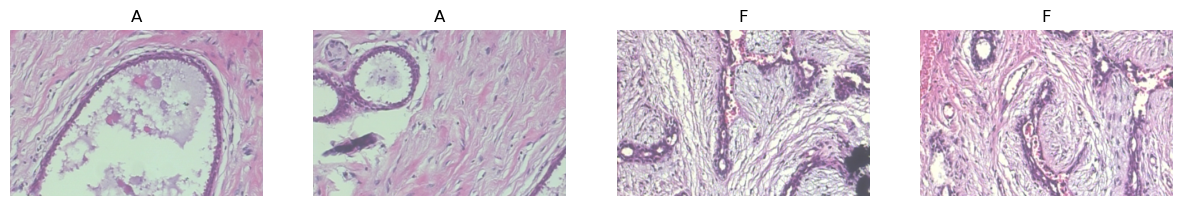

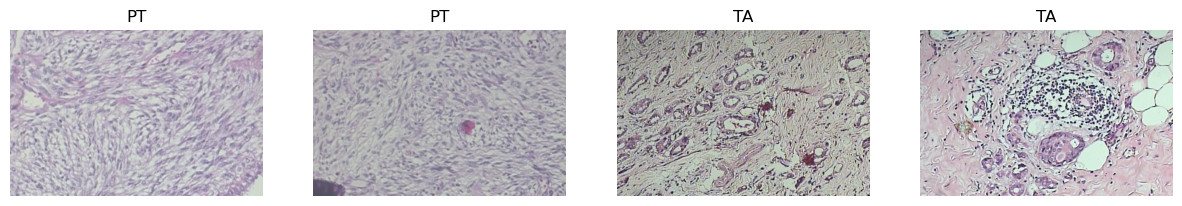

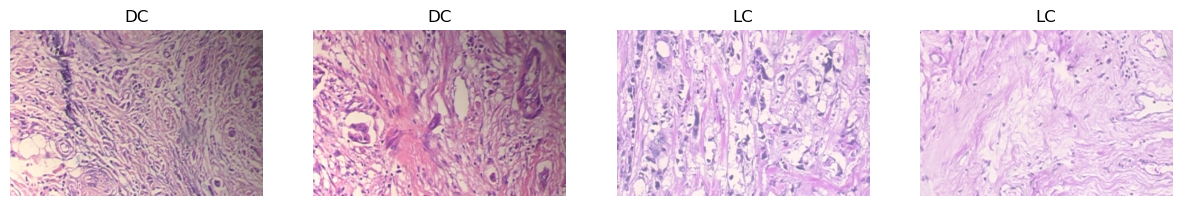

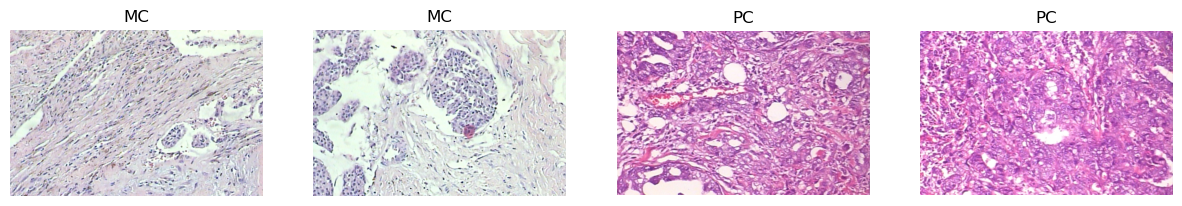

In [19]:
import matplotlib.image as mpimg

def display_images(label1, label2, list1, list2):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, img_path in zip(axes[:2], list1[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label1)  
        ax.axis('off')
    
    for ax, img_path in zip(axes[2:], list2[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label2)
        ax.axis('off')
    plt.show()

# Display images from each list
display_images("A", "F", A, F)
display_images("PT","TA", PT, TA)
display_images("DC","LC", DC, LC)
display_images("MC","PC", MC, PC)

In [26]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters, morphology, color, measure
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.color import rgb2hed
from tqdm import tqdm

# === SETTINGS ===
input_folder = r"C:\Users\pnryl\Downloads\archive (3).zip\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\malignant\SOB" # <-- change this
output_folder = 'segmentation_results'          # <-- save results here
os.makedirs(output_folder, exist_ok=True)

# === PROCESSING FUNCTION ===
def segment_tumor(image_path, save_results=True):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Color Deconvolution
    hed = rgb2hed(image)
    hematoxylin_channel = hed[:, :, 0]

    # Otsu Thresholding
    threshold = filters.threshold_otsu(hematoxylin_channel)
    binary_mask = hematoxylin_channel > threshold

    # Remove small objects
    binary_mask = morphology.remove_small_objects(binary_mask, min_size=500)

    # Distance Transform and Watershed
    distance = ndi.distance_transform_edt(binary_mask)
    local_maxi = morphology.local_maxima(distance)
    markers = measure.label(local_maxi)
    labels = watershed(-distance, markers, mask=binary_mask)

    # Morphological closing
    labels = morphology.closing(labels, morphology.disk(3))

    if save_results:
        filename = os.path.basename(image_path)
        save_path = os.path.join(output_folder, filename)

        # Save colored labels (optional: you can also save binary masks)
        plt.imsave(save_path, labels, cmap='nipy_spectral')

    return labels

# === BATCH PROCESS ALL IMAGES ===
supported_formats = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']
image_paths = [os.path.join(input_folder, f) for f in os.listdir(input_folder)
               if os.path.splitext(f)[-1].lower() in supported_formats]

print(f"Found {len(image_paths)} images. Starting segmentation...")

for img_path in tqdm(image_paths):
    segment_tumor(img_path)

print(f"Segmentation complete! Results saved to '{output_folder}' 🎯")


FileNotFoundError: [WinError 3] Sistem belirtilen yolu bulamıyor: 'C:\\Users\\pnryl\\Downloads\\archive (3).zip\\BreaKHis_v1\\BreaKHis_v1\\histology_slides\\breast\\malignant\\SOB'

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
original_data_dir =r"C:\Users\pnryl\OneDrive\Masaüstü\labview\archive (2)\BreaKHis 400X"
segmented_data_dir = r"C:\Users\pnryl\OneDrive\Masaüstü\labview\archive (1)\BreaKHis_Segmented"
input_shape = (224, 224, 3)
batch_size = 32
epochs = 30

def create_cnn_model(is_segmented=False):
    if is_segmented:
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])
    else:
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def create_transfer_model():
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def get_data_generators(data_dir, is_segmented=False):
    if is_segmented:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='constant',
            cval=0)
    else:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

    return train_generator, test_generator

def train_and_evaluate(data_directory, model_type='cnn', is_segmented=False):
    train_generator, test_generator = get_data_generators(data_directory, is_segmented)

    class_weights = {
        0: train_generator.samples / (2 * np.bincount(train_generator.classes)[0]),
        1: train_generator.samples / (2 * np.bincount(train_generator.classes)[1])
    }

    model = create_transfer_model() if model_type == 'transfer' else create_cnn_model(is_segmented)

    print("\nTraining model...")
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        class_weight=class_weights)

    print("\nEvaluating on test set...")
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\nTest accuracy: {test_acc:.4f}")

    y_pred = model.predict(test_generator)
    y_pred = (y_pred > 0.5).astype(int)
    print("\nClassification Report:")
    print(classification_report(test_generator.classes, y_pred,
                                target_names=['benign', 'malignant']))

    return model, test_acc

def main():
    print("=== BREAKHIS CNN CLASSIFIER ===")

    if not os.path.exists(original_data_dir):
        print(f"Error: Original data directory not found at {original_data_dir}")
        return

    print("1. Training on original images...")
    original_model, original_acc = train_and_evaluate(
        original_data_dir,
        model_type='cnn',
        is_segmented=False
    )

    if os.path.exists(segmented_data_dir):
        print("\n2. Training on segmented images with CNN...")
        segmented_cnn_model, segmented_cnn_acc = train_and_evaluate(
            segmented_data_dir,
            model_type='cnn',
            is_segmented=True
        )

        print("\n3. Training on segmented images with Transfer Learning...")
        segmented_transfer_model, segmented_transfer_acc = train_and_evaluate(
            segmented_data_dir,
            model_type='transfer',
            is_segmented=True
        )

        print("\n=== RESULTS COMPARISON ===")
        print(f"Original images test accuracy: {original_acc:.4f}")
        print(f"Segmented images (CNN) test accuracy: {segmented_cnn_acc:.4f}")
        print(f"Segmented images (Transfer) test accuracy: {segmented_transfer_acc:.4f}")
    else:
        print(f"\nSegmented data directory not found at {segmented_data_dir}")
        print("\n=== FINAL RESULTS ===")
        print(f"Original images test accuracy: {original_acc:.4f}")

if __name__ == "__main__":
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    main()


=== BREAKHIS CNN CLASSIFIER ===
1. Training on original images...
Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.

Training model...


C:\Users\pnryl\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\pnryl\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5892 - loss: 0.7037
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 221us/step - accuracy: 0.7812 - loss: 0.5274
Epoch 3/30


C:\Users\pnryl\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 612ms/step - accuracy: 0.7259 - loss: 0.6431
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 236us/step - accuracy: 0.8438 - loss: 0.4662 
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 593ms/step - accuracy: 0.6917 - loss: 0.6395
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - accuracy: 0.7188 - loss: 0.5971 
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 644ms/step - accuracy: 0.7514 - loss: 0.5695
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step - accuracy: 0.7500 - loss: 0.5572 
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 626ms/step - accuracy: 0.7850 - loss: 0.5643
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 177us/step - accuracy: 0.7188 - loss: 0.6115 
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 631ms/step - accuracy: 0.7399 - loss: 0.5547
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step - accuracy: 0.6875 - loss: 0.6396 
Epoch 13/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 605ms/step - accuracy: 0.8047 - loss: 0.5168
Epoch 14/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 163us/st

C:\Users\pnryl\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\pnryl\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4875 - loss: 1.0862
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 160us/step - accuracy: 0.4375 - loss: 1.2312
Epoch 3/30


C:\Users\pnryl\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 940ms/step - accuracy: 0.5339 - loss: 1.0058
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 193us/step - accuracy: 0.5625 - loss: 1.0871 
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 934ms/step - accuracy: 0.5147 - loss: 0.9597
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 206us/step - accuracy: 0.5938 - loss: 0.9518 
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 930ms/step - accuracy: 0.5369 - loss: 1.0009
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step - accuracy: 0.6250 - loss: 0.7683 
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 926ms/step - accuracy: 0.5483 - loss: 0.9721
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 206us/step - accuracy: 0.5312 - loss: 1.2653 
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 919ms/step - accuracy: 0.5529 - loss: 0.9133
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 191us/step - accuracy: 0.5625 - loss: 0.9851 
Epoch 13/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 33s 924ms/step - accuracy: 0.5773 - loss: 0.8396
Epoch 14/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 163us/st

C:\Users\pnryl\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5071 - loss: 0.9661
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 235us/step - accuracy: 0.5625 - loss: 0.8998
Epoch 3/30


C:\Users\pnryl\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5810 - loss: 0.8405
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 243us/step - accuracy: 0.5000 - loss: 1.0302
Epoch 5/30
24/35 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5925 - loss: 0.8062

KeyboardInterrupt: 

In [ ]:
def load_and_resize_images(img_list, label, size=(128, 128)):
    img_array = []
    for img in img_list:
        # Load image using OpenCV (BGR format)
        image = cv2.imread(img, cv2.IMREAD_COLOR)
        
        # Convert BGR to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Convert the image to a tensor and normalize
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = image / 255.0  # Normalize to [0, 1]
        
        if label != 4:
            # Apply augmentation if label is not 4
            augmented_images = augment_image(image)
            for aug_img in augmented_images:
                # Resize image to the specified size
                image_resized = tf.image.resize(aug_img, size)
                img_array.append([image_resized, label])
        else:
            # For label 4, just resize the image without augmentation
            image_resized = tf.image.resize(image, size)
            img_array.append([image_resized, label])

    return img_array

def augment_image(img):
    augmented_images = []

    # Original image
    augmented_images.append(img)

    # Apply rotations and flips
    for k in [1, 2]:
        rotated_img = tf.image.rot90(img, k=k)
        mirrored_rotated_img = tf.image.flip_left_right(rotated_img)
        augmented_images.append(mirrored_rotated_img)

    return augmented_images

# Example usage:
A_imgs = load_and_resize_images(A, 0)
F_imgs = load_and_resize_images(F, 1)
PT_imgs = load_and_resize_images(PT, 2)
TA_imgs = load_and_resize_images(TA, 3)
DC_imgs = load_and_resize_images(DC, 4)
LC_imgs = load_and_resize_images(LC, 5)
MC_imgs = load_and_resize_images(MC, 6)
PC_imgs = load_and_resize_images(PC, 7)


In [ ]:
def load_and_resize_images(img_list, label, size=(128, 128)):
    img_array = []
    for img in img_list:
        image = cv2.imread(img, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = image / 255.0
        if label != 4:
            augmented_images = augment_image(image)
            for aug_img in augmented_images:
                image_resized = tf.image.resize(aug_img, size)
                img_array.append([image_resized, label])
        else:
            image_resized = tf.image.resize(image, size)
            img_array.append([image_resized, label])

    return img_array

def augment_image(img):
    augmented_images = []

    augmented_images.append(img)

    for k in [1, 2]:
        rotated_img = tf.image.rot90(img, k=k)
        mirrored_rotated_img = tf.image.flip_left_right(rotated_img)
        augmented_images.append(mirrored_rotated_img)

    return augmented_images

A_imgs  = load_and_resize_images(A, 0)
F_imgs  = load_and_resize_images(F, 1)
PT_imgs  = load_and_resize_images(PT, 2)
TA_imgs = load_and_resize_images(TA, 3)
DC_imgs = load_and_resize_images(DC, 4)
LC_imgs = load_and_resize_images(LC, 5)
MC_imgs = load_and_resize_images(MC, 6)
PC_imgs = load_and_resize_images(PC, 7)

Using image: C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\malignant\SOB\ductal_carcinoma\SOB_M_DC_14-16188\100X\SOB_M_DC-14-16188-100-019.png


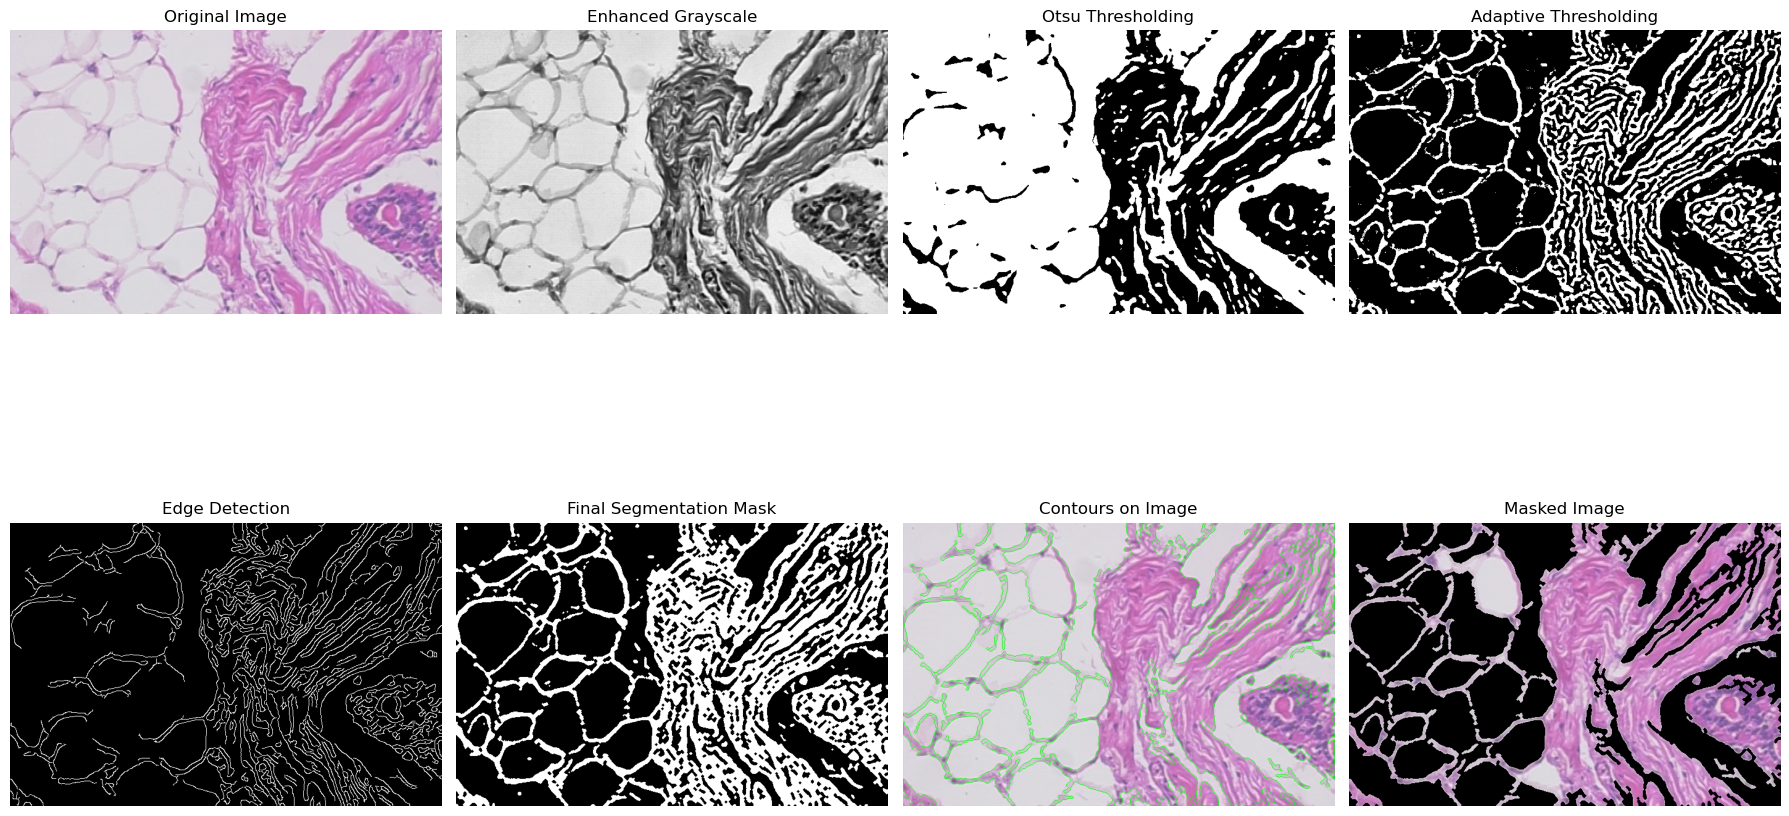

In [130]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import random

def load_and_preprocess(image_path):
    """Load and preprocess the image"""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(image_gray)
    
    # Denoising
    blurred = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)
    
    return image_rgb, image_gray, enhanced, blurred

def segment_image(image_gray, enhanced, blurred):
    """Segment the image using multiple approaches"""
    # Multi-level thresholding
    _, thresh_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Adaptive thresholding
    thresh_adapt = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
    
    # Edge-based segmentation
    edges = cv2.Canny(blurred, 50, 150)
    
    # Combine methods
    combined = cv2.bitwise_or(thresh_adapt, edges)
    
    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    morphed = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=2)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=1)
    
    return thresh_otsu, thresh_adapt, edges, combined, morphed

def find_and_filter_contours(mask, min_area=100):
    """Find contours and filter by area"""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    return filtered_contours

def main():
    # Step 1: Locate dataset images
    dataset_path = Path(r"C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4")
    breast_img_paths = glob.glob(str(dataset_path / "BreaKHis_v1" / "BreaKHis_v1" / "histology_slides" / "breast" / "**" / "*.png"), recursive=True)

    if not breast_img_paths:
        raise FileNotFoundError("No images found in the specified directory.")

    # Step 2: Choose a random image
    sample_image_path = random.choice(breast_img_paths)
    print("Using image:", sample_image_path)

    # Step 3: Load and preprocess
    image_rgb, image_gray, enhanced, blurred = load_and_preprocess(sample_image_path)

    # Step 4: Segmentation
    thresh_otsu, thresh_adapt, edges, combined, morphed = segment_image(image_gray, enhanced, blurred)

    # Step 5: Find and filter contours
    contours = find_and_filter_contours(morphed, min_area=100)
    
    # Step 6: Draw results
    segmented = image_rgb.copy()
    cv2.drawContours(segmented, contours, -1, (0, 255, 0), 1)
    
    # Create a mask from contours
    mask = np.zeros_like(image_gray)
    cv2.drawContours(mask, contours, -1, 255, -1)
    
    # Apply mask to original image
    masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

    # Step 7: Show results
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 4, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 4, 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title("Enhanced Grayscale")
    plt.axis("off")

    plt.subplot(2, 4, 3)
    plt.imshow(thresh_otsu, cmap='gray')
    plt.title("Otsu Thresholding")
    plt.axis("off")

    plt.subplot(2, 4, 4)
    plt.imshow(thresh_adapt, cmap='gray')
    plt.title("Adaptive Thresholding")
    plt.axis("off")

    plt.subplot(2, 4, 5)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis("off")

    plt.subplot(2, 4, 6)
    plt.imshow(morphed, cmap='gray')
    plt.title("Final Segmentation Mask")
    plt.axis("off")

    plt.subplot(2, 4, 7)
    plt.imshow(segmented)
    plt.title("Contours on Image")
    plt.axis("off")

    plt.subplot(2, 4, 8)
    plt.imshow(masked_image)
    plt.title("Masked Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Segmentation Evaluation Metrics:
Edge Correlation: 0.3041
Region Homogeneity (STD): 69.0682
Entropy: 0.9643


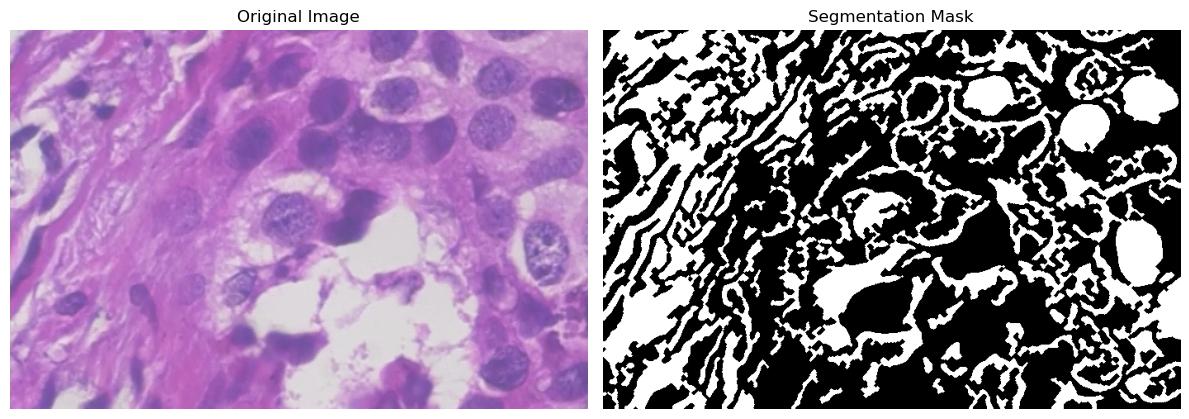

In [134]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import adapted_rand_error, variation_of_information
from skimage.filters import sobel
from skimage.measure import shannon_entropy

def compute_unsupervised_metrics(image, mask):
    """Compute unsupervised segmentation metrics"""
    # 1. Edge Preservation (F-Measure)
    edges_orig = sobel(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    edges_mask = sobel(mask)
    edge_correlation = np.corrcoef(edges_orig.flatten(), edges_mask.flatten())[0, 1]
    
    # 2. Region Homogeneity (lower = better)
    segmented_regions = cv2.bitwise_and(image, image, mask=mask)
    gray_segmented = cv2.cvtColor(segmented_regions, cv2.COLOR_RGB2GRAY)
    region_std = np.std(gray_segmented)
    
    # 3. Entropy (higher = more informative)
    entropy = shannon_entropy(mask)
    
    return {
        "Edge Correlation": edge_correlation,
        "Region Homogeneity (STD)": region_std,
        "Entropy": entropy
    }

# Load and segment the image (using your previous code)
image_rgb, image_gray, enhanced, blurred = load_and_preprocess(sample_image_path)
_, _, _, _, morphed = segment_image(image_gray, enhanced, blurred)
contours = find_and_filter_contours(morphed, min_area=100)

# Create a binary mask from contours
mask = np.zeros_like(image_gray)
cv2.drawContours(mask, contours, -1, 255, -1)

# Compute metrics
metrics = compute_unsupervised_metrics(image_rgb, mask)
print("\nSegmentation Evaluation Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmentation Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters, morphology, color, measure
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.color import rgb2hed
from tqdm import tqdm

# === SETTINGS ===
input_folder = r"C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4"  # <-- change this
output_folder = 'segmentation_results'          # <-- save results here
os.makedirs(output_folder, exist_ok=True)

# === PROCESSING FUNCTION ===
def segment_tumor(image_path, save_results=True):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Color Deconvolution
    hed = rgb2hed(image)
    hematoxylin_channel = hed[:, :, 0]

    # Otsu Thresholding
    threshold = filters.threshold_otsu(hematoxylin_channel)
    binary_mask = hematoxylin_channel > threshold

    # Remove small objects
    binary_mask = morphology.remove_small_objects(binary_mask, min_size=500)

    # Distance Transform and Watershed
    distance = ndi.distance_transform_edt(binary_mask)
    local_maxi = morphology.local_maxima(distance)
    markers = measure.label(local_maxi)
    labels = watershed(-distance, markers, mask=binary_mask)

    # Morphological closing
    labels = morphology.closing(labels, morphology.disk(3))

    if save_results:
        filename = os.path.basename(image_path)
        save_path = os.path.join(output_folder, filename)

        # Save colored labels (optional: you can also save binary masks)
        plt.imsave(save_path, labels, cmap='nipy_spectral')

    return labels

# === BATCH PROCESS ALL IMAGES ===
supported_formats = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']
image_paths = [os.path.join(input_folder, f) for f in os.listdir(input_folder)
               if os.path.splitext(f)[-1].lower() in supported_formats]

print(f"Found {len(image_paths)} images. Starting segmentation...")

for img_path in tqdm(image_paths):
    segment_tumor(img_path)

print(f"Segmentation complete! Results saved to '{output_folder}' 🎯")


Found 0 images. Starting segmentation...


0it [00:00, ?it/s]

Segmentation complete! Results saved to 'segmentation_results' 🎯


In [140]:
data_b = A_imgs + F_imgs + PT_imgs + TA_imgs 
data_m = DC_imgs + LC_imgs + MC_imgs + PC_imgs
print("Total number of benign examples:", len(data_b))
print("Total number of malignant examples:", len(data_m))

random.shuffle(data_b)
random.shuffle(data_m)

# Initial split to separate out the test set (20% of the data)
dataTrain_b, dataTest_b = train_test_split(data_b, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (75% train, 25% val of 80% train-val data)
dataTrain_b, dataVal_b = train_test_split(dataTrain_b, test_size=0.25, random_state=42)

# Initial split to separate out the test set (20% of the data)
dataTrain_m, dataTest_m = train_test_split(data_m, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (75% train, 25% val of 80% train-val data)
dataTrain_m, dataVal_m = train_test_split(dataTrain_m, test_size=0.25, random_state=42)

dataTrain_b_modified = [(image, 0) for image, label in dataTrain_b]
dataTrain_m_modified = [(image, 1) for image, label in dataTrain_m]

dataTrain = dataTrain_b_modified + dataTrain_m_modified
random.shuffle(dataTrain)

dataVal_b_modified = [(image, 0) for image, label in dataVal_b]
dataVal_m_modified = [(image, 1) for image, label in dataVal_m]

dataVal = dataVal_b_modified + dataVal_m_modified
random.shuffle(dataVal)

dataTest_b_modified = [(image, 0) for image, label in dataTest_b]
dataTest_m_modified = [(image, 1) for image, label in dataTest_m]

dataTest = dataTest_b_modified + dataTest_m_modified

print("Total number of examples:", len(dataTrain) + len(dataVal) + len(dataTest))

Total number of benign examples: 7440
Total number of malignant examples: 9385
Total number of examples: 16825


In [146]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)  # Convert images to numpy array
    labels = np.array(labels)
    
    # One-hot encode labels
    labels = tf.keras.utils.to_categorical(labels, num_classes=2)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

with tf.device('/GPU:0'):
    train_dataset = create_tf_dataset(dataTrain)
    val_dataset = create_tf_dataset(dataVal)
    test_dataset = create_tf_dataset(dataTest)

In [150]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [153]:
# Base Model
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
# base_model.trainable = False
# Extract intermediate layers
layer_names = ['conv3_block12_concat', 'conv4_block24_concat', 'conv5_block16_concat']
intermediate_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create a new model that outputs intermediate layers
intermediate_model = Model(inputs=base_model.input, outputs=intermediate_outputs)

# Define the branches for each intermediate output
branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)
# Concatenate the branch outputs for score-level fusion
fusion = tf.keras.layers.Concatenate()(branch_outputs)

# Final dense layers
x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(2, activation='softmax')(x)

# Combine everything into a model
binary_model = Model(inputs=base_model.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)

binary_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [157]:
import time

start_time = time.time()

history = binary_model.fit(train_dataset,
                           validation_data=val_dataset,
                           epochs=50,
                           callbacks=[early_stopping, reduce_lr])

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 730s 5s/step - accuracy: 0.9587 - loss: 0.4753 - val_accuracy: 0.9388 - val_loss: 0.5556 - learning_rate: 1.0000e-04
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 675s 4s/step - accuracy: 0.9714 - loss: 0.4259 - val_accuracy: 0.9462 - val_loss: 0.4645 - learning_rate: 1.0000e-04
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 655s 4s/step - accuracy: 0.9826 - loss: 0.3821 - val_accuracy: 0.9620 - val_loss: 0.4133 - learning_rate: 1.0000e-04
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 662s 4s/step - accuracy: 0.9841 - loss: 0.3623 - val_accuracy: 0.9590 - val_loss: 0.4271 - learning_rate: 1.0000e-04
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 663s 4s/step - accuracy: 0.9856 - loss: 0.3391 - val_accuracy: 0.9560 - val_loss: 0.4199 - learning_rate: 1.0000e-04
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 657s 4s/step - accuracy: 0.9918 - loss: 0.3124 - val_accuracy: 0.9406 - val_loss: 0.4549 - learning_rate: 1.0000e-04
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 661s 4s/step - acc


KeyboardInterrupt



In [1]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set dataset path
dataset_path = Path(r"C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4")
image_folder = dataset_path / "BreakHis"  # adjust if needed


In [5]:
def segment_tumor_region(image_path):
    img = cv2.imread(str(image_path))
    img = cv2.resize(img, (224, 224))  # Resize for simplicity
    
    # Convert to LAB and enhance contrast
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0)
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu thresholding
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert: tumors usually darker
    mask = 255 - mask

    # Optional morphological cleanup
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    return img, cleaned


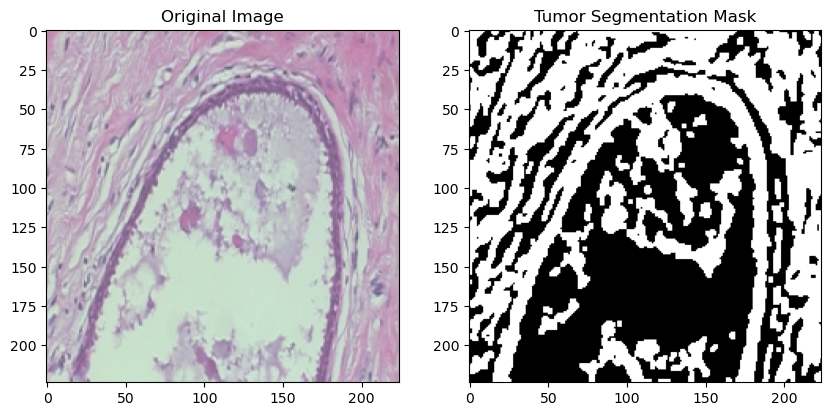

In [19]:
sample_image = next(image_folder.glob("**/*.png"))  # or .jpg
original, mask = segment_tumor_region(sample_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Tumor Segmentation Mask")
plt.show()


In [9]:
print(dataset_path)
print(list(dataset_path.glob("*")))


C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4
[WindowsPath('C:/Users/pnryl/.cache/kagglehub/datasets/ambarish/breakhis/versions/4/BreaKHis_v1'), WindowsPath('C:/Users/pnryl/.cache/kagglehub/datasets/ambarish/breakhis/versions/4/Folds.csv')]


In [11]:
image_files = list(dataset_path.glob("**/*.[jpJP][pnPN]*[gG]"))  # matches .jpg, .png, .JPG, etc.

print(f"Found {len(image_files)} images.")
if image_files:
    sample_image = image_files[0]
    print(f"Sample image: {sample_image}")


Found 7909 images.
Sample image: C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\benign\SOB\adenosis\SOB_B_A_14-22549AB\100X\SOB_B_A-14-22549AB-100-001.png


In [13]:
image_folder = dataset_path / "BreaKHis_v1"


In [17]:
from pathlib import Path

image_folder = Path(r"C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4\BreaKHis_v1")
image_files = list(image_folder.rglob("*.png"))

print(f"Found {len(image_files)} images.")
if image_files:
    sample_image = image_files[0]
    print(f"Sample image path: {sample_image}")


Found 7909 images.
Sample image path: C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\benign\SOB\adenosis\SOB_B_A_14-22549AB\100X\SOB_B_A-14-22549AB-100-001.png


In [27]:
# e.g. using OpenCV + skimage (Macenko)
from skimage import io
from histomicstk.preprocessing.color_normalization import reinhard
img = io.imread(path)
img_norm = reinhard(img, target_means, target_stds)


ModuleNotFoundError: No module named 'histomicstk'

In [29]:
pip install staintools scikit-image



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14056 sha256=c9acc947cf838f18967b2c7bb53f24b8ca676042d6a85ae59006ff71ad46de81
  Stored in directory: c:\users\pnryl\appdata\local\pip\cache\wheels\4d\ae\02\336aa637aaa26e83b7baa062700b6e39aa1378aaa930195afa
Successfully built staintools


In [34]:
import cv2
import numpy as np
from pathlib import Path

def reinhard_normalize(src_bgr, tgt_bgr):
    """
    Perform Reinhard normalization of src to match tgt in LAB space.
    src_bgr, tgt_bgr: uint8 BGR images (0–255)
    """
    # Convert to LAB and float
    src_lab = cv2.cvtColor(src_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    tgt_lab = cv2.cvtColor(tgt_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)

    # Compute per-channel mean/std
    for i in range(3):
        s_chan = src_lab[..., i]
        t_chan = tgt_lab[..., i]
        src_lab[..., i] = ((s_chan - s_chan.mean()) / (s_chan.std() + 1e-8)
                            * t_chan.std()) + t_chan.mean()

    # Clip & convert back
    src_lab = np.clip(src_lab, 0, 255).astype(np.uint8)
    return cv2.cvtColor(src_lab, cv2.COLOR_LAB2BGR)

# ————————————————————————————————————————————————————
# Folder setup
base_folder = Path(r"C:\Users\pnryl\.cache\kagglehub\datasets\ambarish\breakhis\versions\4\BreaKHis_v1")
output_root = Path(r"C:\…\breakhis_reinhard")

# Group by magnification
import re
mag2paths = {}
for p in base_folder.rglob("*.[jp][pn]g"):
    m = re.search(r"(\d+)X", p.name)
    if m:
        mag = m.group(1) + "X"
        mag2paths.setdefault(mag, []).append(p)

# Pick one target per magnification
targets = {
    mag: cv2.imread(str(paths[0]))
    for mag, paths in mag2paths.items()
}

# Process & save
for mag, paths in mag2paths.items():
    tgt = targets[mag]
    out_dir = output_root / mag / "reinhard"
    out_dir.mkdir(parents=True, exist_ok=True)

    for p in paths:
        src = cv2.imread(str(p))
        norm = reinhard_normalize(src, tgt)
        cv2.imwrite(str(out_dir / p.name), norm)


In [45]:
conda install -c conda-forge spams
pip install staintools


SyntaxError: invalid syntax (768899028.py, line 1)

In [44]:
!conda install -c conda-forge spams -y
!pip install staintools


Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... failed



PackagesNotFoundError: The following packages are not available from current channels:

  - spams

Current channels:

  - https://conda.anaconda.org/conda-forge
  - defaults
  - https://repo.anaconda.com/pkgs/main
  - https://repo.anaconda.com/pkgs/r
  - https://repo.anaconda.com/pkgs/msys2

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [ ]:
import staintools
normalizer = staintools.StainNormalizer(method='macenko')


In [51]:
import cv2
import numpy as np
from pathlib import Path

# 1) point to your reinhard-normalized folder
#    (output_root/<mag>/reinhard/*.png)
reinhard_root = Path(r"C:\…\breakhis_reinhard")

def remove_background(img_bgr):
    """Return a binary mask of tissue vs white background."""
    # convert to gray
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # anything very bright is background
    _, tissue_mask = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
    # clean up small specks
    kernel = np.ones((5,5), np.uint8)
    tissue_mask = cv2.morphologyEx(tissue_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    tissue_mask = cv2.dilate(tissue_mask, kernel, iterations=2)
    return tissue_mask

# 2) loop a single magnification to test
mag = "40X"
in_folder  = reinhard_root / mag / "reinhard"
out_folder = reinhard_root / mag / "tissue_masks"
out_folder.mkdir(exist_ok=True, parents=True)

for p in in_folder.glob("*.png"):
    img = cv2.imread(str(p))
    mask = remove_background(img)
    # save a 3-channel mask for easy visualization
    cv2.imwrite(str(out_folder / p.name), cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR))

print(f"Saved tissue masks to {out_folder}")


Saved tissue masks to C:\…\breakhis_reinhard\40X\tissue_masks


In [55]:
# pseudocode example
tissue_only = cv2.bitwise_and(gray_image, gray_image, mask=tissue_mask)
_, tumor_mask = cv2.threshold(tissue_only, 0, 255,
                              cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


NameError: name 'gray_image' is not defined

In [57]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def remove_background(img_bgr):
    """Return binary mask isolating tissue region (not background)."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.dilate(mask, kernel, iterations=2)
    return mask

def segment_tumor_with_otsu(img_bgr, tissue_mask):
    """Apply Otsu segmentation inside the tissue region."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    tissue_gray = cv2.bitwise_and(gray, gray, mask=tissue_mask)
    _, tumor_mask = cv2.threshold(tissue_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return tumor_mask

# Load any sample from your reinhard-normalized folder
img_path = Path(r"C:\…\breakhis_reinhard\40X\reinhard\your_sample.png")
img = cv2.imread(str(img_path))

# Segment pipeline
tissue_mask = remove_background(img)
tumor_mask = segment_tumor_with_otsu(img, tissue_mask)

# Show it
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(tissue_mask, cmap='gray'); plt.title("Tissue Region")
plt.subplot(1,3,3); plt.imshow(tumor_mask, cmap='gray'); plt.title("Tumor Region (Otsu)")
plt.tight_layout()
plt.show()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Found 961 images belonging to 4 classes.
Found 429 images belonging to 4 classes.
Training classes: {'ductal_carcinoma': 0, 'lobular_carcinoma': 1, 'mucinous_carcinoma': 2, 'papillary_carcinoma': 3}
Testing classes: {'ductal_carcinoma': 0, 'lobular_carcinoma': 1, 'mucinous_carcinoma': 2, 'papillary_carcinoma': 3}
Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.5644 - loss: 1.1664 - val_accuracy: 0.5524 - val_loss: 1.1822 - learning_rate: 1.0000e-04
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.6903 - loss: 0.8677 - val_accuracy: 0.5221 - val_loss: 1.1822 - learning_rate: 1.0000e-04
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7195 - loss: 0.7570 - val_accuracy: 0.5315 - val_loss: 1.2000 - learning_rate: 1.0000e-04
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.7124 - loss: 0.7087 - val_accuracy: 0.4476 - val_loss: 1.2125 - learning_rate: 1.0000e-04
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.7447 

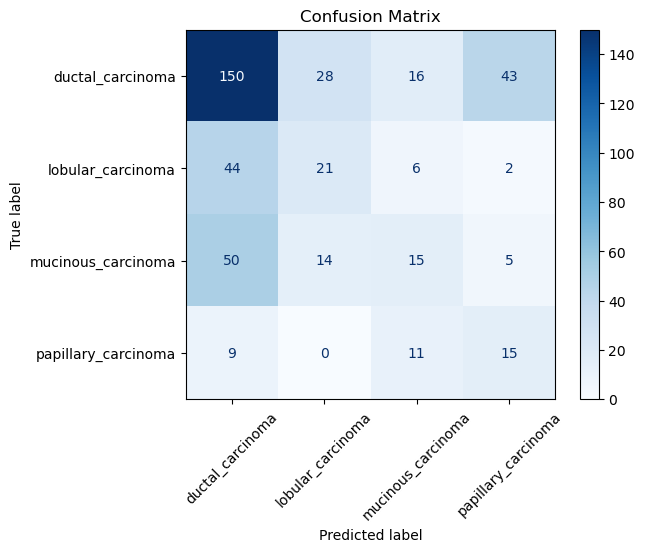

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Directories - change these if needed
train_dir = r"P:\BreaKHis_v1\200\data\train_mal"
test_dir  = r"P:\BreaKHis_v1\200\data\test_mal"

# Image dimensions
img_height, img_width = 224, 224
num_classes = 4  # Only 4 malignant subclasses

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

# Print classes for verification
print("Training classes:", train_generator.class_indices)
print("Testing classes:", test_generator.class_indices)

# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze last few layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate schedule
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train
model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[lr_scheduler]
)

# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy:.2f}')

# Predictions
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Y_pred_proba = model.predict(test_generator, verbose=1)
Y_pred = np.argmax(Y_pred_proba, axis=1)

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Directories - change these if needed
train_dir = r"P:\BreaKHis_v1\200\data\train_b"
test_dir  = r"P:\BreaKHis_v1\200\data\test_b"

# Image dimensions
img_height, img_width = 224, 224
num_classes = 4  # Only 4 malignant subclasses

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=10,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

# Print classes for verification
print("Training classes:", train_generator.class_indices)
print("Testing classes:", test_generator.class_indices)

# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze last few layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate schedule
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train
model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=[lr_scheduler]
)

# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy:.2f}')

# Predictions
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Y_pred_proba = model.predict(test_generator, verbose=1)
Y_pred = np.argmax(Y_pred_proba, axis=1)

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


Found 455 images belonging to 4 classes.
Found 168 images belonging to 4 classes.
Training classes: {'adenosis': 0, 'fibroadenoma': 1, 'phyllodes_tumor': 2, 'tubular_adenoma': 3}
Testing classes: {'adenosis': 0, 'fibroadenoma': 1, 'phyllodes_tumor': 2, 'tubular_adenoma': 3}


C:\Users\pnryl\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 965ms/step - accuracy: 0.4075 - loss: 1.3838 - val_accuracy: 0.4464 - val_loss: 1.3675 - learning_rate: 1.0000e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 932ms/step - accuracy: 0.6042 - loss: 0.9551 - val_accuracy: 0.4405 - val_loss: 1.4921 - learning_rate: 1.0000e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 938ms/step - accuracy: 0.7029 - loss: 0.6993 - val_accuracy: 0.3095 - val_loss: 1.6860 - learning_rate: 1.0000e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 928ms/step - accuracy: 0.7287 - loss: 0.6990 - val_accuracy: 0.3988 - val_loss: 1.7293 - learning_rate: 1.0000e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 930ms/step - accuracy: 0.7370 - loss: 0.6319 - val_accuracy: 0.3631 - val_loss: 2.3204 - learning_rate: 1.0000e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.7809 - loss: 0.5214
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 928ms/step - accuracy:

KeyboardInterrupt: 

Found 961 images belonging to 4 classes.
Found 429 images belonging to 4 classes.
Training classes: {'ductal_carcinoma': 0, 'lobular_carcinoma': 1, 'mucinous_carcinoma': 2, 'papillary_carcinoma': 3}
Testing classes: {'ductal_carcinoma': 0, 'lobular_carcinoma': 1, 'mucinous_carcinoma': 2, 'papillary_carcinoma': 3}
Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.5220 - loss: 1.3338 - val_accuracy: 0.5524 - val_loss: 1.2786 - learning_rate: 1.0000e-04
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.6623 - loss: 0.9984 - val_accuracy: 0.5524 - val_loss: 1.3513 - learning_rate: 1.0000e-04
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.6801 - loss: 0.9047 - val_accuracy: 0.5524 - val_loss: 1.3843 - learning_rate: 1.0000e-04
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.6990 - loss: 0.8521 - val_accuracy: 0.5455 - val_loss: 1.3727 - learning_rate: 1.0000e-04
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.

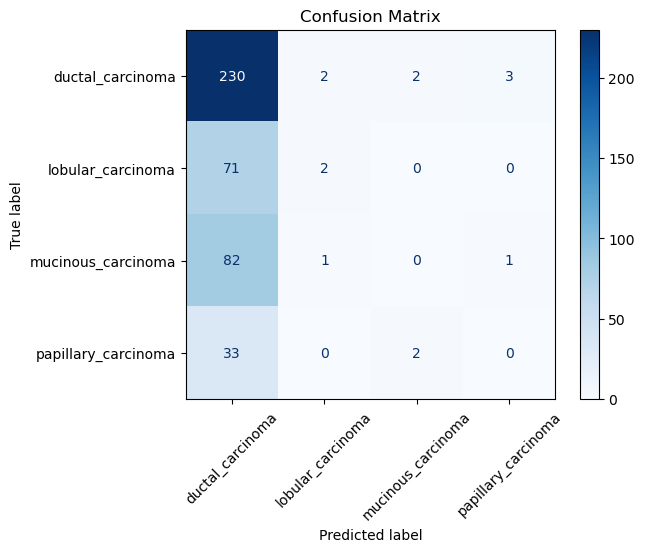

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Directories
train_dir = r"P:\BreaKHis_v1\200\data\train_mal"
test_dir  = r"P:\BreaKHis_v1\200\data\test_mal"

# Image dimensions for InceptionResNetV2
img_height, img_width = 299, 299
num_classes = 4  # Only malignant subclasses

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Check class count
print("Training classes:", train_generator.class_indices)
print("Testing classes:", test_generator.class_indices)
assert len(train_generator.class_indices) == 4, "Expected 4 malignant subclasses in training data."
assert len(test_generator.class_indices) == 4, "Expected 4 malignant subclasses in test data."

# Load base model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze most layers
for layer in base_model.layers:
    layer.trainable = False

# Add classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train
model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=[lr_scheduler]
)

# Evaluate
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy:.2f}')

# Predictions
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Y_pred_proba = model.predict(test_generator, verbose=1)
Y_pred = np.argmax(Y_pred_proba, axis=1)

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Folder paths (malignant folder contains only 4 subclass folders)
train_dir = r"P:\BreaKHis_v1\200\data\train_b"
test_dir  = r"P:\BreaKHis_v1\200\data\test_b"

# InceptionResNetV2 input image size
img_height, img_width = 299, 299
num_classes = 4  # ductal_carcinoma, lobular_carcinoma, mucinous_carcinoma, papillary_carcinoma

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Print to confirm class mapping
print("Training classes:", train_generator.class_indices)
print("Testing classes:", test_generator.class_indices)

# Load InceptionResNetV2 base model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze most layers, unfreeze last few
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Custom classifier head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=[lr_scheduler]
)

# Evaluate on test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy:.2f}')

# Predictions and confusion matrix
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Y_pred_proba = model.predict(test_generator, verbose=1)
Y_pred = np.argmax(Y_pred_proba, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


Found 455 images belonging to 4 classes.
Found 168 images belonging to 4 classes.
Training classes: {'adenosis': 0, 'fibroadenoma': 1, 'phyllodes_tumor': 2, 'tubular_adenoma': 3}
Testing classes: {'adenosis': 0, 'fibroadenoma': 1, 'phyllodes_tumor': 2, 'tubular_adenoma': 3}

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.3277 - loss: 1.4326 - val_accuracy: 0.3274 - val_loss: 1.5112 - learning_rate: 1.0000e-04
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.5856 - loss: 1.0416 - val_accuracy: 0.3333 - val_loss: 1.5135 - learning_rate: 1.0000e-04
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.5608 - loss: 0.9421 - val_accuracy: 0.3333 - val_loss: 1.5251 - learning_rate: 1.0000e-04
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.6215 - loss: 0.8463 - val_accuracy: 0.3452 - val_loss: 1.4040 - learning_rate: 1.0000e-04
Epoch 5/15
 4/15 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6576 - loss: 0.8232

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Paths to malignant subclass folders (each should contain 4 folders)
train_dir = r"P:\BreaKHis_v1\200\data\train_b"
test_dir  = r"P:\BreaKHis_v1\200\data\test_b"

# Image size required by Xception
img_height, img_width = 299, 299
num_classes = 4  # Number of malignant subclasses

# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=15,
    class_mode='categorical',
    shuffle=False  # Keep order for confusion matrix
)

# Print class mapping
print("Training classes:", train_generator.class_indices)
print("Testing classes:", test_generator.class_indices)

# Load base Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze most layers and unfreeze a few at the end
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[lr_scheduler]
)

# Evaluate model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy:.2f}')

# Predictions
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Y_pred_proba = model.predict(test_generator, verbose=1)
Y_pred = np.argmax(Y_pred_proba, axis=1)

# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()
